# Run interventions in loop with OpenABM 

In [15]:
import sys
sys.path.insert(0,'./src/')
from pathlib import Path
import log, logging
from importlib import reload
import loop_abm

#logging
output_dir = "./output/"
fold_out = Path(output_dir)
if not fold_out.exists():
    fold_out.mkdir(parents=True)

reload(log)
logger = log.setup_logger()

Log setup already done


## Epidemic model

#### set parameters of the openABM foward simulation

In [2]:
N=50000 #Number of individuals
T=100 #Total time of simulations
seed = 1 #random seed
n_seed_infection = 10 #number of patient zero

params_model = {
    "rng_seed" : seed,
    "end_time" : T,
    "n_total"  : N,
    "days_of_interactions" : T,
    "n_seed_infection" : n_seed_infection,
}

## Set testing and quarantine rules

In [3]:
fraction_SM_obs = 0.5 #fraction of Symptomatic Mild tested positive
fraction_SS_obs = 1 #fraction of Symptomatic Severe tested positive
initial_steps = 12 #starting time of intervention
quarantine_HH = True #Households quarantine
test_HH = True #Tests the households when quarantined
adoption_fraction = 1 #app adoption (fraction)
num_test_random = 0 #number of random tests per day
num_test_algo = 200 #number of tests using by the ranker per day

## Choose the rankers algorithms class

In [4]:
from rankers import dotd_rank, tracing_rank, mean_field_rank, sib_rank
import sib


prob_seed = 1/N
prob_sus = 0.55
pseed = prob_seed / (2 - prob_seed)
psus = prob_sus * (1 - pseed)
pautoinf = 1/N
fp_rate = 0.0
fn_rate = 0.0


dotd = dotd_rank.DotdRanker()

tracing = tracing_rank.TracingRanker(
                 tau=5,
                 lamb=0.014
)

MF = mean_field_rank.MeanFieldRanker(
                tau = 5,
                delta = 10,
                mu = 1/30,
                lamb = 0.014
                )


sib_ranker = sib_rank.SibRanker(
                 params = sib.Params(
                                 prob_i = sib.Cached(sib.Scaled(sib.PDF(sib.Gamma(k=5.76, mu=0.96)), scale=0.25), T+1),
                                 prob_r = sib.Cached(sib.Gamma(k = 10, mu = 1/1.7452974337097158), T+1),
                                 pseed = pseed,
                                 psus = psus,
                                 fp_rate = fp_rate,
                                 fn_rate = fn_rate,
                                 pautoinf = pautoinf),
                 maxit0 = 20,
                 maxit1 = 20,
                 tol = 1e-3,
                 memory_decay = 1e-5,
                 window_length = 21,
                 tau=7
)


ress = {}


In [5]:
rankers = {
    "random" : dotd,
    "tracing": tracing,
   "MF" : MF,
  "sib_ranker": sib_ranker,

} 

### Set up figure

In [6]:
%matplotlib widget
import matplotlib.pyplot as plt
import plot_utils
import time

plots = plot_utils.plot_style(N, T)
save_path_fig = f"./output/plot_run_N_{N}_SM_{fraction_SM_obs}_test_{num_test_algo}_n_seed_infection_{n_seed_infection}_seed_{seed}.png"
fig, callback = plot_utils.plotgrid(rankers, plots, initial_steps, save_path=save_path_fig)
time.sleep(0.5)
fig.canvas

Canvas(header_visible=False, toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Bac…

In [7]:
import imp 
imp.reload(loop_abm)

for s in rankers:
    data = {"algo":s}
    loop_abm.loop_abm(
        params_model, 
        rankers[s], 
        seed=seed, 
        logger = logging.getLogger(f"iteration.{s}"), 
        data = data, 
        callback = callback,
        initial_steps = initial_steps, 
        num_test_random = num_test_random,
        num_test_algo = num_test_algo,
        fraction_SM_obs = fraction_SM_obs,
        fraction_SS_obs = fraction_SS_obs,
        quarantine_HH = quarantine_HH,
        test_HH = test_HH,
        adoption_fraction = adoption_fraction,
        fp_rate = fp_rate,
        fn_rate = fn_rate,
        name_file_res = s + f"_N_{N}_T_{T}_obs_{num_test_algo}_SM_obs_{fraction_SM_obs}_seed_{seed}"
    )
    ress[s] = data
    # saves a bit of memory: rankers[s] = {}

COVID19.model: INFO     Returning self.c_params into Model object, future updates to parameters not possible
COVID19.model: INFO     Started model creation
COVID19.model: INFO     Successfuly created model
COVID19.model: INFO     Started model creation
COVID19.model: INFO     Successfuly created model
iteration.random: INFO     time:0
iteration.random: INFO     number of unique contacts: 632210
iteration.random: INFO     True  : (S,I,R): (49990.0, 10.0, 0.0)
iteration.random: INFO     AUR_I : 0.492, prec(1% of 50001): 0.00, prec5%: 0.00
iteration.random: INFO     SS: 0, SM: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.random: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.random: INFO     ...quarantining 0 guys -> got 0 infected, 10 free as birds (+10)
iteration.random: INFO     time:1
iteration.random: INFO     number of unique contacts: 632414
iteration.random: INFO     True  : (S,I,R): (49988.0, 12.0, 0.0)
iteration.random: INFO     AUR_I : 0.499, pr

sib.iterate(damp=0):  2/20 1.056e-06/0.001    
sib.iterate(damp=0.5):  0/20 1.815e-08/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49999.1, 0.9, 0.0), seeds: 0.9, ll: -29890.6
iteration.sib_ranker: INFO     True  : (S,I,R): (49990.0, 10.0, 0.0)
iteration.sib_ranker: INFO     AUR_I : 0.426, prec(1% of 50001): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 10 free as birds (+10)
iteration.sib_ranker: INFO     time:1
iteration.sib_ranker: INFO     number of unique contacts: 632414


sib.iterate(damp=0):  2/20 6.499e-06/0.001    
sib.iterate(damp=0.5):  0/20 4.853e-07/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49998.3, 1.7, 0.0), seeds: 0.9, ll: -29889.9
iteration.sib_ranker: INFO     True  : (S,I,R): (49988.0, 12.0, 0.0)
iteration.sib_ranker: INFO     AUR_I : 0.324, prec(1% of 50001): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 1, SM: 1, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 7 guys -> got 3 infected, 9 free as birds (-1)
iteration.sib_ranker: INFO     time:2
iteration.sib_ranker: INFO     number of unique contacts: 632688


sib.iterate(damp=0):  2/20 2.278e-05/0.001    
sib.iterate(damp=0.5):  0/20 2.902e-06/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49997.4, 2.6, 0.0), seeds: 0.8, ll: -29892.8
iteration.sib_ranker: INFO     True  : (S,I,R): (49983.0, 17.0, 0.0)
iteration.sib_ranker: INFO     AUR_I : 0.668, prec(1% of 49994): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 14 free as birds (+5)
iteration.sib_ranker: INFO     time:3
iteration.sib_ranker: INFO     number of unique contacts: 632572


sib.iterate(damp=0):  2/20 6.391e-05/0.001    
sib.iterate(damp=0.5):  0/20 1.246e-05/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49996.4, 3.6, 0.0), seeds: 0.7, ll: -29918.6
iteration.sib_ranker: INFO     True  : (S,I,R): (49980.0, 20.0, 0.0)
iteration.sib_ranker: INFO     AUR_I : 0.676, prec(1% of 49994): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 1, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 3 guys -> got 1 infected, 16 free as birds (+2)
iteration.sib_ranker: INFO     time:4
iteration.sib_ranker: INFO     number of unique contacts: 632250


sib.iterate(damp=0):  2/20 9.047e-05/0.001    
sib.iterate(damp=0.5):  0/20 2.816e-05/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49995.2, 4.8, 0.0), seeds: 0.6, ll: -30012.4
iteration.sib_ranker: INFO     True  : (S,I,R): (49972.0, 28.0, 0.0)
iteration.sib_ranker: INFO     AUR_I : 0.620, prec(1% of 49991): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 1, SM: 1, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 5 guys -> got 2 infected, 21 free as birds (+5)
iteration.sib_ranker: INFO     time:5
iteration.sib_ranker: INFO     number of unique contacts: 632788


sib.iterate(damp=0):  2/20 1.339e-04/0.001    
sib.iterate(damp=0.5):  0/20 5.642e-05/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49993.9, 6.1, 0.0), seeds: 0.5, ll: -30237.4
iteration.sib_ranker: INFO     True  : (S,I,R): (49970.0, 30.0, 0.0)
iteration.sib_ranker: INFO     AUR_I : 0.592, prec(1% of 49986): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 1, SM: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 3 guys -> got 1 infected, 22 free as birds (+1)
iteration.sib_ranker: INFO     time:6
iteration.sib_ranker: INFO     number of unique contacts: 632666


sib.iterate(damp=0):  2/20 1.990e-04/0.001    
sib.iterate(damp=0.5):  0/20 8.523e-05/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49992.6, 7.4, 0.0), seeds: 0.5, ll: -30644.3
iteration.sib_ranker: INFO     True  : (S,I,R): (49964.0, 36.0, 0.0)
iteration.sib_ranker: INFO     AUR_I : 0.560, prec(1% of 49983): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 28 free as birds (+6)
iteration.sib_ranker: INFO     time:7
iteration.sib_ranker: INFO     number of unique contacts: 631766


sib.iterate(damp=0):  2/20 3.445e-04/0.001    
sib.iterate(damp=0.5):  0/20 1.335e-04/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49991.2, 8.7, 0.0), seeds: 0.4, ll: -31252.0
iteration.sib_ranker: INFO     True  : (S,I,R): (49956.0, 44.0, 0.0)
iteration.sib_ranker: INFO     AUR_I : 0.561, prec(1% of 49983): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 1, SM: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 2 guys -> got 2 infected, 32 free as birds (+4)
iteration.sib_ranker: INFO     time:8
iteration.sib_ranker: INFO     number of unique contacts: 631494


sib.iterate(damp=0):  2/20 3.046e-04/0.001        
sib.iterate(damp=0.5):  0/20 1.905e-04/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49990.0, 10.0, 0.0), seeds: 0.3, ll: -32009.7
iteration.sib_ranker: INFO     True  : (S,I,R): (49945.0, 54.0, 1.0)
iteration.sib_ranker: INFO     AUR_I : 0.563, prec(1% of 49981): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 1, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 3 guys -> got 2 infected, 41 free as birds (+9)
iteration.sib_ranker: INFO     time:9
iteration.sib_ranker: INFO     number of unique contacts: 631900


sib.iterate(damp=0):  2/20 3.784e-04/0.001    
sib.iterate(damp=0.5):  0/20 2.012e-04/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49988.8, 11.2, 0.0), seeds: 0.3, ll: -32856.5
iteration.sib_ranker: INFO     True  : (S,I,R): (49934.0, 65.0, 1.0)
iteration.sib_ranker: INFO     AUR_I : 0.624, prec(1% of 49978): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 52 free as birds (+11)
iteration.sib_ranker: INFO     time:10
iteration.sib_ranker: INFO     number of unique contacts: 632824


sib.iterate(damp=0):  2/20 4.490e-04/0.001    
sib.iterate(damp=0.5):  0/20 2.710e-04/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49987.8, 12.2, 0.1), seeds: 0.3, ll: -33706.2
iteration.sib_ranker: INFO     True  : (S,I,R): (49926.0, 73.0, 1.0)
iteration.sib_ranker: INFO     AUR_I : 0.598, prec(1% of 49978): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 1, SM: 1, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 8 guys -> got 6 infected, 54 free as birds (+2)
iteration.sib_ranker: INFO     time:11
iteration.sib_ranker: INFO     number of unique contacts: 631306


sib.iterate(damp=0):  2/20 4.736e-04/0.001    
sib.iterate(damp=0.5):  0/20 2.491e-04/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49986.9, 13.0, 0.1), seeds: 0.2, ll: -34531.7
iteration.sib_ranker: INFO     True  : (S,I,R): (49913.0, 86.0, 1.0)
iteration.sib_ranker: INFO     AUR_I : 0.595, prec(1% of 49970): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 1, SM: 1, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 5 guys -> got 2 infected, 65 free as birds (+11)
iteration.sib_ranker: INFO     
observation-based inference algorithm starts now

iteration.sib_ranker: INFO     time:12
iteration.sib_ranker: INFO     number of unique contacts: 632968


sib.iterate(damp=0):  19/20 4.259e-01/0.001       
sib.iterate(damp=0.5):  19/20 6.120e-01/0.001           


iteration.sib_ranker: INFO     winBP: (S,I,R): (49963.8, 34.9, 1.4), seeds: 2.9, ll: -30083.5
iteration.sib_ranker: INFO     True  : (S,I,R): (49897.0, 101.0, 2.0)
iteration.sib_ranker: INFO     AUR_I : 0.590, prec(1% of 49954): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 1, results test algo (S,I,R): (196,4,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 15 guys -> got 7 infected, 73 free as birds (+8)
iteration.sib_ranker: INFO     time:13
iteration.sib_ranker: INFO     number of unique contacts: 632072


sib.iterate(damp=0):  19/20 9.449e-01/0.001        
sib.iterate(damp=0.5):  19/20 1.935e-01/0.001       


iteration.sib_ranker: INFO     winBP: (S,I,R): (49967.2, 32.4, 0.4), seeds: 0.5, ll: -29971.7
iteration.sib_ranker: INFO     True  : (S,I,R): (49882.0, 113.0, 5.0)
iteration.sib_ranker: INFO     AUR_I : 0.561, prec(1% of 49939): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 3, SM: 2, results test algo (S,I,R): (197,3,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 25 guys -> got 11 infected, 76 free as birds (+3)
iteration.sib_ranker: INFO     time:14
iteration.sib_ranker: INFO     number of unique contacts: 630192


sib.iterate(damp=0):  19/20 1.987e-01/0.001    
sib.iterate(damp=0.5):  19/20 4.434e-01/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49933.6, 65.1, 1.3), seeds: 1.1, ll: -31274.9
iteration.sib_ranker: INFO     True  : (S,I,R): (49868.0, 126.0, 6.0)
iteration.sib_ranker: INFO     AUR_I : 0.654, prec(1% of 49884): 0.01, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 2, results test algo (S,I,R): (184,15,1), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 47 guys -> got 22 infected, 67 free as birds (-9)
iteration.sib_ranker: INFO     time:15
iteration.sib_ranker: INFO     number of unique contacts: 630490


sib.iterate(damp=0):  19/20 5.438e-01/0.001       
sib.iterate(damp=0.5):  19/20 6.167e-02/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49918.0, 78.6, 3.4), seeds: 1.2, ll: -29605.7
iteration.sib_ranker: INFO     True  : (S,I,R): (49846.0, 146.0, 8.0)
iteration.sib_ranker: INFO     AUR_I : 0.667, prec(1% of 49851): 0.01, prec5%: 0.01
iteration.sib_ranker: INFO     SS: 4, SM: 1, results test algo (S,I,R): (187,13,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 42 guys -> got 22 infected, 65 free as birds (-2)
iteration.sib_ranker: INFO     time:16
iteration.sib_ranker: INFO     number of unique contacts: 628480


sib.iterate(damp=0):  19/20 8.673e-01/0.001    
sib.iterate(damp=0.5):  19/20 4.886e-01/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49874.4, 119.3, 6.3), seeds: 2.6, ll: -29891.9
iteration.sib_ranker: INFO     True  : (S,I,R): (49825.0, 165.0, 10.0)
iteration.sib_ranker: INFO     AUR_I : 0.754, prec(1% of 49795): 0.00, prec5%: 0.01
iteration.sib_ranker: INFO     SS: 0, SM: 1, results test algo (S,I,R): (182,18,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 46 guys -> got 24 infected, 58 free as birds (-7)
iteration.sib_ranker: INFO     time:17
iteration.sib_ranker: INFO     number of unique contacts: 628800


sib.iterate(damp=0):  19/20 9.955e-01/0.001        
sib.iterate(damp=0.5):  19/20 5.595e-01/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49822.1, 169.4, 8.5), seeds: 2.3, ll: -31178.1
iteration.sib_ranker: INFO     True  : (S,I,R): (49811.0, 171.0, 18.0)
iteration.sib_ranker: INFO     AUR_I : 0.700, prec(1% of 49765): 0.00, prec5%: 0.01
iteration.sib_ranker: INFO     SS: 1, SM: 2, results test algo (S,I,R): (194,6,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 35 guys -> got 9 infected, 60 free as birds (+2)
iteration.sib_ranker: INFO     time:18
iteration.sib_ranker: INFO     number of unique contacts: 627772


sib.iterate(damp=0):  19/20 9.580e-01/0.001           
sib.iterate(damp=0.5):  19/20 1.602e-01/0.001           


iteration.sib_ranker: INFO     winBP: (S,I,R): (49837.7, 153.9, 8.4), seeds: 1.5, ll: -29856.8
iteration.sib_ranker: INFO     True  : (S,I,R): (49791.0, 188.0, 21.0)
iteration.sib_ranker: INFO     AUR_I : 0.737, prec(1% of 49746): 0.01, prec5%: 0.01
iteration.sib_ranker: INFO     SS: 1, SM: 1, results test algo (S,I,R): (197,3,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 13 guys -> got 5 infected, 69 free as birds (+9)
iteration.sib_ranker: INFO     time:19
iteration.sib_ranker: INFO     number of unique contacts: 627862


sib.iterate(damp=0):  19/20 8.736e-01/0.001    
sib.iterate(damp=0.5):  19/20 2.192e-01/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49820.0, 168.0, 11.9), seeds: 1.7, ll: -30228.3
iteration.sib_ranker: INFO     True  : (S,I,R): (49773.0, 202.0, 25.0)
iteration.sib_ranker: INFO     AUR_I : 0.685, prec(1% of 49713): 0.00, prec5%: 0.01
iteration.sib_ranker: INFO     SS: 1, SM: 0, results test algo (S,I,R): (190,10,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 33 guys -> got 15 infected, 68 free as birds (-1)
iteration.sib_ranker: INFO     time:20
iteration.sib_ranker: INFO     number of unique contacts: 627580


sib.iterate(damp=0):  19/20 7.901e-01/0.001       
sib.iterate(damp=0.5):  19/20 1.432e-01/0.001        


iteration.sib_ranker: INFO     winBP: (S,I,R): (49805.3, 179.5, 15.1), seeds: 1.6, ll: -30412.5
iteration.sib_ranker: INFO     True  : (S,I,R): (49758.0, 213.0, 29.0)
iteration.sib_ranker: INFO     AUR_I : 0.677, prec(1% of 49684): 0.01, prec5%: 0.01
iteration.sib_ranker: INFO     SS: 0, SM: 3, results test algo (S,I,R): (192,8,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 37 guys -> got 13 infected, 65 free as birds (-3)
iteration.sib_ranker: INFO     time:21
iteration.sib_ranker: INFO     number of unique contacts: 625688


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 0.8991865148133797
sib.iterate(damp=0):  19/20 9.978e-01/0.001        
sib.iterate(damp=0.5):  19/20 6.255e-01/0.001           


iteration.sib_ranker: INFO     winBP: (S,I,R): (49748.0, 224.1, 27.9), seeds: 4.4, ll: -52985.5
iteration.sib_ranker: INFO     True  : (S,I,R): (49749.0, 214.0, 37.0)
iteration.sib_ranker: INFO     AUR_I : 0.709, prec(1% of 49656): 0.02, prec5%: 0.01
iteration.sib_ranker: INFO     SS: 1, SM: 0, results test algo (S,I,R): (194,6,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 17 guys -> got 7 infected, 62 free as birds (-3)
iteration.sib_ranker: INFO     time:22
iteration.sib_ranker: INFO     number of unique contacts: 626338


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 1.7120954571971305
sib.iterate(damp=0):  19/20 6.459e-01/0.001    
sib.iterate(damp=0.5):  19/20 1.719e-01/0.001       


iteration.sib_ranker: INFO     winBP: (S,I,R): (49772.1, 204.0, 24.0), seeds: 2.9, ll: -50372.9
iteration.sib_ranker: INFO     True  : (S,I,R): (49733.0, 221.0, 46.0)
iteration.sib_ranker: INFO     AUR_I : 0.675, prec(1% of 49621): 0.01, prec5%: 0.01
iteration.sib_ranker: INFO     SS: 3, SM: 0, results test algo (S,I,R): (189,11,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 40 guys -> got 19 infected, 54 free as birds (-8)
iteration.sib_ranker: INFO     time:23
iteration.sib_ranker: INFO     number of unique contacts: 624848


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 2.60414002079119
sib.iterate(damp=0):  19/20 3.695e-01/0.001    
sib.iterate(damp=0.5):  19/20 2.189e-01/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49744.2, 226.4, 29.4), seeds: 4.4, ll: -50777.2
iteration.sib_ranker: INFO     True  : (S,I,R): (49711.0, 238.0, 51.0)
iteration.sib_ranker: INFO     AUR_I : 0.635, prec(1% of 49609): 0.01, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 1, SM: 4, results test algo (S,I,R): (198,2,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 21 guys -> got 13 infected, 54 free as birds (+0)
iteration.sib_ranker: INFO     time:24
iteration.sib_ranker: INFO     number of unique contacts: 624796


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 3.6384450819743437
sib.iterate(damp=0):  19/20 6.222e-01/0.001    
sib.iterate(damp=0.5):  19/20 3.011e-01/0.001        


iteration.sib_ranker: INFO     winBP: (S,I,R): (49718.9, 244.5, 36.6), seeds: 5.6, ll: -50518.1
iteration.sib_ranker: INFO     True  : (S,I,R): (49699.0, 243.0, 58.0)
iteration.sib_ranker: INFO     AUR_I : 0.686, prec(1% of 49565): 0.01, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 1, results test algo (S,I,R): (186,13,1), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 31 guys -> got 15 infected, 43 free as birds (-11)
iteration.sib_ranker: INFO     time:25
iteration.sib_ranker: INFO     number of unique contacts: 623398


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 4.814665811978408
sib.iterate(damp=0):  19/20 9.854e-01/0.001       
sib.iterate(damp=0.5):  19/20 3.989e-01/0.001        


iteration.sib_ranker: INFO     winBP: (S,I,R): (49689.3, 265.3, 45.3), seeds: 8.0, ll: -51037.6
iteration.sib_ranker: INFO     True  : (S,I,R): (49687.0, 243.0, 70.0)
iteration.sib_ranker: INFO     AUR_I : 0.712, prec(1% of 49541): 0.01, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 1, SM: 1, results test algo (S,I,R): (194,6,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 24 guys -> got 10 infected, 40 free as birds (-3)
iteration.sib_ranker: INFO     time:26
iteration.sib_ranker: INFO     number of unique contacts: 623602


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 6.090632632506975
sib.iterate(damp=0):  19/20 2.327e-01/0.001        
sib.iterate(damp=0.5):  19/20 3.505e-02/0.001               


iteration.sib_ranker: INFO     winBP: (S,I,R): (49682.4, 264.7, 52.9), seeds: 9.9, ll: -50912.7
iteration.sib_ranker: INFO     True  : (S,I,R): (49667.0, 256.0, 77.0)
iteration.sib_ranker: INFO     AUR_I : 0.687, prec(1% of 49525): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (193,6,1), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 12 guys -> got 7 infected, 44 free as birds (+4)
iteration.sib_ranker: INFO     time:27
iteration.sib_ranker: INFO     number of unique contacts: 623336


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 7.415626797736465
sib.iterate(damp=0):  19/20 8.514e-01/0.001    
sib.iterate(damp=0.5):  19/20 4.643e-02/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49668.7, 267.4, 63.9), seeds: 12.3, ll: -50993.6
iteration.sib_ranker: INFO     True  : (S,I,R): (49653.0, 251.0, 96.0)
iteration.sib_ranker: INFO     AUR_I : 0.673, prec(1% of 49489): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (190,9,1), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 35 guys -> got 12 infected, 41 free as birds (-3)
iteration.sib_ranker: INFO     time:28
iteration.sib_ranker: INFO     number of unique contacts: 623330


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 8.735840035759352
sib.iterate(damp=0):  19/20 2.804e-01/0.001       
sib.iterate(damp=0.5):  19/20 4.673e-02/0.001        


iteration.sib_ranker: INFO     winBP: (S,I,R): (49647.5, 277.4, 75.2), seeds: 15.4, ll: -51070.5
iteration.sib_ranker: INFO     True  : (S,I,R): (49640.0, 253.0, 107.0)
iteration.sib_ranker: INFO     AUR_I : 0.623, prec(1% of 49480): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 2, SM: 0, results test algo (S,I,R): (196,4,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 14 guys -> got 8 infected, 43 free as birds (+2)
iteration.sib_ranker: INFO     time:29
iteration.sib_ranker: INFO     number of unique contacts: 622718


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 9.998496225230213
sib.iterate(damp=0):  19/20 2.776e-01/0.001           
sib.iterate(damp=0.5):  19/20 2.696e-03/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49638.3, 273.9, 87.9), seeds: 20.3, ll: -51085.3
iteration.sib_ranker: INFO     True  : (S,I,R): (49630.0, 249.0, 121.0)
iteration.sib_ranker: INFO     AUR_I : 0.642, prec(1% of 49454): 0.01, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 1, SM: 0, results test algo (S,I,R): (193,7,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 24 guys -> got 10 infected, 41 free as birds (-2)
iteration.sib_ranker: INFO     time:30
iteration.sib_ranker: INFO     number of unique contacts: 621514


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 11.153349615455795
sib.iterate(damp=0):  19/20 7.180e-01/0.001           
sib.iterate(damp=0.5):  19/20 1.241e-02/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49621.4, 276.3, 102.3), seeds: 25.4, ll: -51027.1
iteration.sib_ranker: INFO     True  : (S,I,R): (49619.0, 250.0, 131.0)
iteration.sib_ranker: INFO     AUR_I : 0.552, prec(1% of 49423): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 2, SM: 1, results test algo (S,I,R): (189,11,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 34 guys -> got 14 infected, 30 free as birds (-11)
iteration.sib_ranker: INFO     time:31
iteration.sib_ranker: INFO     number of unique contacts: 622050


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 12.16273163990162
sib.iterate(damp=0):  19/20 6.315e-01/0.001    
sib.iterate(damp=0.5):  19/20 2.548e-02/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49595.2, 288.1, 116.7), seeds: 30.3, ll: -51139.4
iteration.sib_ranker: INFO     True  : (S,I,R): (49610.0, 240.0, 150.0)
iteration.sib_ranker: INFO     AUR_I : 0.765, prec(1% of 49398): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (189,10,1), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 18 guys -> got 12 infected, 20 free as birds (-10)
iteration.sib_ranker: INFO     time:32
iteration.sib_ranker: INFO     number of unique contacts: 620904


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 13.029994475209907
sib.iterate(damp=0):  19/20 1.141e-02/0.001           
sib.iterate(damp=0.5):  8/20 8.250e-04/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49585.6, 283.9, 130.4), seeds: 41.8, ll: -51292.0
iteration.sib_ranker: INFO     True  : (S,I,R): (49599.0, 235.0, 166.0)
iteration.sib_ranker: INFO     AUR_I : 0.636, prec(1% of 49389): 0.01, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 1, results test algo (S,I,R): (197,3,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 9 guys -> got 4 infected, 22 free as birds (+2)
iteration.sib_ranker: INFO     time:33
iteration.sib_ranker: INFO     number of unique contacts: 621156


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 34.86047726706727
sib.iterate(damp=0):  18/20 9.153e-04/0.001        
sib.iterate(damp=0.5):  0/20 8.965e-04/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49585.6, 273.6, 140.9), seeds: 51.1, ll: -51326.8
iteration.sib_ranker: INFO     True  : (S,I,R): (49591.0, 229.0, 180.0)
iteration.sib_ranker: INFO     AUR_I : 0.686, prec(1% of 49383): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 1, SM: 1, results test algo (S,I,R): (198,2,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 12 guys -> got 4 infected, 21 free as birds (-1)
iteration.sib_ranker: INFO     time:34
iteration.sib_ranker: INFO     number of unique contacts: 620894


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 32.417449204042114
sib.iterate(damp=0):  19/20 9.509e-01/0.001           
sib.iterate(damp=0.5):  19/20 1.114e-01/0.001        


iteration.sib_ranker: INFO     winBP: (S,I,R): (49596.8, 255.7, 147.5), seeds: 66.4, ll: -51275.2
iteration.sib_ranker: INFO     True  : (S,I,R): (49581.0, 225.0, 194.0)
iteration.sib_ranker: INFO     AUR_I : 0.750, prec(1% of 49364): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (195,5,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 12 guys -> got 5 infected, 18 free as birds (-3)
iteration.sib_ranker: INFO     time:35
iteration.sib_ranker: INFO     number of unique contacts: 621306


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 65.07616168880945
sib.iterate(damp=0):  12/20 6.585e-04/0.001    
sib.iterate(damp=0.5):  0/20 8.605e-04/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49609.7, 236.6, 153.7), seeds: 75.0, ll: -51196.7
iteration.sib_ranker: INFO     True  : (S,I,R): (49573.0, 221.0, 206.0)
iteration.sib_ranker: INFO     AUR_I : 0.724, prec(1% of 49358): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (196,4,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 6 guys -> got 5 infected, 15 free as birds (-3)
iteration.sib_ranker: INFO     time:36
iteration.sib_ranker: INFO     number of unique contacts: 620592


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 78.60493458947388
sib.iterate(damp=0):  16/20 5.643e-04/0.001    
sib.iterate(damp=0.5):  0/20 2.994e-04/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49620.7, 226.2, 153.1), seeds: 84.4, ll: -51142.7
iteration.sib_ranker: INFO     True  : (S,I,R): (49565.0, 209.0, 226.0)
iteration.sib_ranker: INFO     AUR_I : 0.556, prec(1% of 49331): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (193,7,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 27 guys -> got 8 infected, 9 free as birds (-6)
iteration.sib_ranker: INFO     time:37
iteration.sib_ranker: INFO     number of unique contacts: 619720


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 119.29975416849229
sib.iterate(damp=0):  19/20 3.195e-01/0.001    
sib.iterate(damp=0.5):  19/20 8.645e-02/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49631.2, 212.5, 156.3), seeds: 89.5, ll: -50995.5
iteration.sib_ranker: INFO     True  : (S,I,R): (49561.0, 197.0, 242.0)
iteration.sib_ranker: INFO     AUR_I : 0.666, prec(1% of 49320): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (197,3,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 11 guys -> got 4 infected, 6 free as birds (-3)
iteration.sib_ranker: INFO     time:38
iteration.sib_ranker: INFO     number of unique contacts: 620616


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 169.42272602909443
sib.iterate(damp=0):  19/20 inf/0.001    
sib.iterate(damp=0.5):  19/20 inf/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49625.6, 198.6, 175.8), seeds: 106.9, ll: -inf
iteration.sib_ranker: INFO     True  : (S,I,R): (49560.0, 186.0, 254.0)
iteration.sib_ranker: INFO     AUR_I : 0.475, prec(1% of 49312): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (198,2,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 8 guys -> got 2 infected, 5 free as birds (-1)
iteration.sib_ranker: INFO     time:39
iteration.sib_ranker: INFO     number of unique contacts: 620016


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 153.87345173072217
sib.iterate(damp=0):  19/20 1.319e-03/0.001       
sib.iterate(damp=0.5):  0/20 5.564e-04/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49648.0, 177.8, 174.2), seeds: 111.3, ll: -50990.4
iteration.sib_ranker: INFO     True  : (S,I,R): (49555.0, 175.0, 270.0)
iteration.sib_ranker: INFO     AUR_I : 0.363, prec(1% of 49310): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (199,1,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 2 guys -> got 2 infected, 5 free as birds (+0)
iteration.sib_ranker: INFO     time:40
iteration.sib_ranker: INFO     number of unique contacts: 620008


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 168.04243433027264
sib.iterate(damp=0):  19/20 inf/0.001       
sib.iterate(damp=0.5):  19/20 inf/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49663.1, 164.7, 172.2), seeds: 112.6, ll: -inf
iteration.sib_ranker: INFO     True  : (S,I,R): (49551.0, 164.0, 285.0)
iteration.sib_ranker: INFO     AUR_I : 0.441, prec(1% of 49304): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (199,1,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 6 guys -> got 1 infected, 3 free as birds (-2)
iteration.sib_ranker: INFO     time:41
iteration.sib_ranker: INFO     number of unique contacts: 619608


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 179.53516795310568
sib.iterate(damp=0):  9/20 4.647e-04/0.001    
sib.iterate(damp=0.5):  0/20 9.679e-05/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49675.8, 151.9, 172.3), seeds: 114.2, ll: -50869.6
iteration.sib_ranker: INFO     True  : (S,I,R): (49547.0, 158.0, 295.0)
iteration.sib_ranker: INFO     AUR_I : 0.388, prec(1% of 49302): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (199,1,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 2 guys -> got 1 infected, 2 free as birds (-1)
iteration.sib_ranker: INFO     time:42
iteration.sib_ranker: INFO     number of unique contacts: 618642


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 224.09300775984494
sib.iterate(damp=0):  19/20 2.669e-01/0.001        
sib.iterate(damp=0.5):  19/20 1.965e-02/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49664.3, 141.4, 194.3), seeds: 139.4, ll: -50711.4
iteration.sib_ranker: INFO     True  : (S,I,R): (49544.0, 146.0, 310.0)
iteration.sib_ranker: INFO     AUR_I : 0.537, prec(1% of 49302): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 2 free as birds (+0)
iteration.sib_ranker: INFO     time:43
iteration.sib_ranker: INFO     number of unique contacts: 620232


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 203.94994010906026
sib.iterate(damp=0):  18/20 4.337e-04/0.001        
sib.iterate(damp=0.5):  0/20 2.475e-04/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49700.5, 129.6, 169.9), seeds: 116.7, ll: -50788.6
iteration.sib_ranker: INFO     True  : (S,I,R): (49542.0, 130.0, 328.0)
iteration.sib_ranker: INFO     AUR_I : 0.445, prec(1% of 49302): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 2 free as birds (+0)
iteration.sib_ranker: INFO     time:44
iteration.sib_ranker: INFO     number of unique contacts: 619566


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 226.41150379333956
sib.iterate(damp=0):  19/20 1.822e-02/0.001        
sib.iterate(damp=0.5):  10/20 4.730e-04/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49707.2, 117.4, 175.3), seeds: 129.7, ll: -50749.9
iteration.sib_ranker: INFO     True  : (S,I,R): (49540.0, 121.0, 339.0)
iteration.sib_ranker: INFO     AUR_I : 0.422, prec(1% of 49302): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 2 free as birds (+0)
iteration.sib_ranker: INFO     time:45
iteration.sib_ranker: INFO     number of unique contacts: 619466


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 244.515479986826
sib.iterate(damp=0):  14/20 9.925e-04/0.001    
sib.iterate(damp=0.5):  0/20 9.982e-04/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49721.8, 106.2, 171.9), seeds: 127.9, ll: -50647.4
iteration.sib_ranker: INFO     True  : (S,I,R): (49539.0, 115.0, 346.0)
iteration.sib_ranker: INFO     AUR_I : 0.426, prec(1% of 49302): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 2 free as birds (+0)
iteration.sib_ranker: INFO     time:46
iteration.sib_ranker: INFO     number of unique contacts: 618968


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 265.3472835271483
sib.iterate(damp=0):  14/20 7.838e-04/0.001    
sib.iterate(damp=0.5):  0/20 5.310e-04/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49723.4, 97.2, 179.4), seeds: 137.2, ll: -50597.7
iteration.sib_ranker: INFO     True  : (S,I,R): (49537.0, 106.0, 357.0)
iteration.sib_ranker: INFO     AUR_I : 0.489, prec(1% of 49302): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 2 free as birds (+0)
iteration.sib_ranker: INFO     time:47
iteration.sib_ranker: INFO     number of unique contacts: 620482


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 264.70292785359806
sib.iterate(damp=0):  14/20 9.559e-04/0.001           
sib.iterate(damp=0.5):  0/20 3.730e-04/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49738.2, 86.6, 175.2), seeds: 135.8, ll: -50565.1
iteration.sib_ranker: INFO     True  : (S,I,R): (49534.0, 101.0, 365.0)
iteration.sib_ranker: INFO     AUR_I : 0.597, prec(1% of 49302): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 3 free as birds (+1)
iteration.sib_ranker: INFO     time:48
iteration.sib_ranker: INFO     number of unique contacts: 619350


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 267.42866285104657
sib.iterate(damp=0):  19/20 inf/0.001       
sib.iterate(damp=0.5):  19/20 inf/0.001           


iteration.sib_ranker: INFO     winBP: (S,I,R): (49751.8, 79.9, 168.3), seeds: 129.8, ll: -inf
iteration.sib_ranker: INFO     True  : (S,I,R): (49533.0, 91.0, 376.0)
iteration.sib_ranker: INFO     AUR_I : 0.606, prec(1% of 49302): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 3 free as birds (+0)
iteration.sib_ranker: INFO     time:49
iteration.sib_ranker: INFO     number of unique contacts: 620722


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 277.36031779997927
sib.iterate(damp=0):  19/20 inf/0.001        
sib.iterate(damp=0.5):  19/20 inf/0.001        


iteration.sib_ranker: INFO     winBP: (S,I,R): (49757.9, 71.1, 171.0), seeds: 137.0, ll: -inf
iteration.sib_ranker: INFO     True  : (S,I,R): (49532.0, 84.0, 384.0)
iteration.sib_ranker: INFO     AUR_I : 0.539, prec(1% of 49302): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 4 free as birds (+1)
iteration.sib_ranker: INFO     time:50
iteration.sib_ranker: INFO     number of unique contacts: 621170


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 273.85567796883595
sib.iterate(damp=0):  9/20 4.476e-04/0.001    
sib.iterate(damp=0.5):  0/20 1.950e-04/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49781.4, 56.6, 162.0), seeds: 137.8, ll: -50432.8
iteration.sib_ranker: INFO     True  : (S,I,R): (49532.0, 72.0, 396.0)
iteration.sib_ranker: INFO     AUR_I : 0.523, prec(1% of 49302): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 3 free as birds (-1)
iteration.sib_ranker: INFO     time:51
iteration.sib_ranker: INFO     number of unique contacts: 619366


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 276.3319591085254
sib.iterate(damp=0):  7/20 6.864e-04/0.001    
sib.iterate(damp=0.5):  0/20 1.776e-04/0.001    


iteration.sib_ranker: INFO     winBP: (S,I,R): (49796.4, 50.2, 153.3), seeds: 134.4, ll: -50364.6
iteration.sib_ranker: INFO     True  : (S,I,R): (49532.0, 65.0, 403.0)
iteration.sib_ranker: INFO     AUR_I : 0.535, prec(1% of 49302): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 1, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 5 guys -> got 1 infected, 2 free as birds (-1)
iteration.sib_ranker: INFO     time:52
iteration.sib_ranker: INFO     number of unique contacts: 619660


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 288.0747060683318
sib.iterate(damp=0):  19/20 3.866e-01/0.001    
sib.iterate(damp=0.5):  19/20 1.619e-01/0.001                   


iteration.sib_ranker: INFO     winBP: (S,I,R): (49803.4, 46.1, 150.6), seeds: 135.5, ll: -50258.7
iteration.sib_ranker: INFO     True  : (S,I,R): (49532.0, 59.0, 409.0)
iteration.sib_ranker: INFO     AUR_I : nan, prec(1% of 49295): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (198,1,1), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 2 guys -> got 2 infected, 0 free as birds (-2)
iteration.sib_ranker: INFO     time:53
iteration.sib_ranker: INFO     number of unique contacts: 618976


faster end


iteration.sib_ranker: INFO     True  : (S,I,R): (49532.0, 52.0, 416.0)
iteration.sib_ranker: INFO     AUR_I : nan, prec(1% of 49294): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.sib_ranker: INFO     time:54
iteration.sib_ranker: INFO     number of unique contacts: 619560


faster end


iteration.sib_ranker: INFO     True  : (S,I,R): (49531.0, 51.0, 418.0)
iteration.sib_ranker: INFO     AUR_I : nan, prec(1% of 49294): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.sib_ranker: INFO     time:55
iteration.sib_ranker: INFO     number of unique contacts: 619302


faster end


iteration.sib_ranker: INFO     True  : (S,I,R): (49531.0, 45.0, 424.0)
iteration.sib_ranker: INFO     AUR_I : nan, prec(1% of 49294): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.sib_ranker: INFO     time:56
iteration.sib_ranker: INFO     number of unique contacts: 619244


faster end


iteration.sib_ranker: INFO     True  : (S,I,R): (49531.0, 40.0, 429.0)
iteration.sib_ranker: INFO     AUR_I : nan, prec(1% of 49294): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.sib_ranker: INFO     time:57
iteration.sib_ranker: INFO     number of unique contacts: 618296


faster end


iteration.sib_ranker: INFO     True  : (S,I,R): (49531.0, 33.0, 436.0)
iteration.sib_ranker: INFO     AUR_I : nan, prec(1% of 49294): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.sib_ranker: INFO     time:58
iteration.sib_ranker: INFO     number of unique contacts: 619536


faster end


iteration.sib_ranker: INFO     True  : (S,I,R): (49531.0, 29.0, 440.0)
iteration.sib_ranker: INFO     AUR_I : nan, prec(1% of 49294): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.sib_ranker: INFO     time:59
iteration.sib_ranker: INFO     number of unique contacts: 619516


faster end


iteration.sib_ranker: INFO     True  : (S,I,R): (49531.0, 24.0, 445.0)
iteration.sib_ranker: INFO     AUR_I : nan, prec(1% of 49294): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.sib_ranker: INFO     time:60
iteration.sib_ranker: INFO     number of unique contacts: 620132


faster end


iteration.sib_ranker: INFO     True  : (S,I,R): (49531.0, 22.0, 447.0)
iteration.sib_ranker: INFO     AUR_I : nan, prec(1% of 49294): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.sib_ranker: INFO     time:61
iteration.sib_ranker: INFO     number of unique contacts: 618970


faster end


iteration.sib_ranker: INFO     True  : (S,I,R): (49531.0, 18.0, 451.0)
iteration.sib_ranker: INFO     AUR_I : nan, prec(1% of 49294): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.sib_ranker: INFO     time:62
iteration.sib_ranker: INFO     number of unique contacts: 619400


faster end


iteration.sib_ranker: INFO     True  : (S,I,R): (49531.0, 14.0, 455.0)
iteration.sib_ranker: INFO     AUR_I : nan, prec(1% of 49294): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.sib_ranker: INFO     time:63
iteration.sib_ranker: INFO     number of unique contacts: 620008


faster end


iteration.sib_ranker: INFO     True  : (S,I,R): (49531.0, 12.0, 457.0)
iteration.sib_ranker: INFO     AUR_I : nan, prec(1% of 49294): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.sib_ranker: INFO     time:64
iteration.sib_ranker: INFO     number of unique contacts: 619362


faster end


iteration.sib_ranker: INFO     True  : (S,I,R): (49531.0, 11.0, 458.0)
iteration.sib_ranker: INFO     AUR_I : nan, prec(1% of 49294): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.sib_ranker: INFO     time:65
iteration.sib_ranker: INFO     number of unique contacts: 620854


faster end


iteration.sib_ranker: INFO     True  : (S,I,R): (49531.0, 8.0, 461.0)
iteration.sib_ranker: INFO     AUR_I : nan, prec(1% of 49294): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.sib_ranker: INFO     time:66
iteration.sib_ranker: INFO     number of unique contacts: 618488


faster end


iteration.sib_ranker: INFO     True  : (S,I,R): (49531.0, 7.0, 462.0)
iteration.sib_ranker: INFO     AUR_I : nan, prec(1% of 49294): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.sib_ranker: INFO     time:67
iteration.sib_ranker: INFO     number of unique contacts: 620260


faster end


iteration.sib_ranker: INFO     True  : (S,I,R): (49531.0, 5.0, 464.0)
iteration.sib_ranker: INFO     AUR_I : nan, prec(1% of 49294): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.sib_ranker: INFO     time:68
iteration.sib_ranker: INFO     number of unique contacts: 620206


faster end


iteration.sib_ranker: INFO     True  : (S,I,R): (49531.0, 2.0, 467.0)
iteration.sib_ranker: INFO     AUR_I : nan, prec(1% of 49294): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.sib_ranker: INFO     time:69
iteration.sib_ranker: INFO     number of unique contacts: 620194


faster end


iteration.sib_ranker: INFO     True  : (S,I,R): (49531.0, 2.0, 467.0)
iteration.sib_ranker: INFO     AUR_I : nan, prec(1% of 49294): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.sib_ranker: INFO     time:70
iteration.sib_ranker: INFO     number of unique contacts: 619576


faster end


iteration.sib_ranker: INFO     True  : (S,I,R): (49531.0, 2.0, 467.0)
iteration.sib_ranker: INFO     AUR_I : nan, prec(1% of 49294): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.sib_ranker: INFO     time:71
iteration.sib_ranker: INFO     number of unique contacts: 620236


faster end


iteration.sib_ranker: INFO     True  : (S,I,R): (49531.0, 2.0, 467.0)
iteration.sib_ranker: INFO     AUR_I : nan, prec(1% of 49294): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.sib_ranker: INFO     time:72
iteration.sib_ranker: INFO     number of unique contacts: 620314


faster end


iteration.sib_ranker: INFO     True  : (S,I,R): (49531.0, 2.0, 467.0)
iteration.sib_ranker: INFO     AUR_I : nan, prec(1% of 49294): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.sib_ranker: INFO     time:73
iteration.sib_ranker: INFO     number of unique contacts: 618460


faster end


iteration.sib_ranker: INFO     True  : (S,I,R): (49531.0, 2.0, 467.0)
iteration.sib_ranker: INFO     AUR_I : nan, prec(1% of 49294): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.sib_ranker: INFO     time:74
iteration.sib_ranker: INFO     number of unique contacts: 620502


faster end


iteration.sib_ranker: INFO     True  : (S,I,R): (49531.0, 2.0, 467.0)
iteration.sib_ranker: INFO     AUR_I : nan, prec(1% of 49294): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.sib_ranker: INFO     time:75
iteration.sib_ranker: INFO     number of unique contacts: 619150


faster end


iteration.sib_ranker: INFO     True  : (S,I,R): (49531.0, 1.0, 468.0)
iteration.sib_ranker: INFO     AUR_I : nan, prec(1% of 49294): 0.00, prec5%: 0.00
iteration.sib_ranker: INFO     SS: 0, SM: 0, results test algo (S,I,R): (200,0,0), infected test random: 0/0
iteration.sib_ranker: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.sib_ranker: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.sib_ranker: INFO     stopping simulation as there are no more infected individuals


## Results
[see complete results in the output folder]

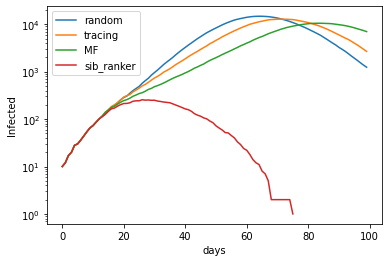

In [14]:
%matplotlib inline
to_plot = "I"
for s in ress.keys():
    plt.plot(ress[s][to_plot], label = s)
plt.semilogy()
plt.ylabel("Infected")
plt.xlabel("days")
plt.legend()
plt.show()